The goal of this notebook is to understand what the error term in the Polya Fourier Expansion (instantiated at $H = (\log p)^2$) should intuitively be. <br> 

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import timeit
from functools import partial
from tqdm import tqdm
import multiprocessing
import random
import os

In [18]:
def legendre(a, p):
    """
    Computes (a / p) i.e. a on p using built in kronecker function, which 
    is a generalization of the legendre symbol. 
    """
    b = a % p # this optimization is prob built into sage but whatever 
    return kronecker(b, p)

def primes(k):
    """
    Returns kth prime (k = 0 => 2)
    """
    P = Primes()
    return P.unrank(k)

def get_range(p):
    """
    Returns index for prime
    Can be optimized with binary search
    but not a big deal
    """
    n = 0 
    while primes(n) < p:
        n += 1 
        
    return n

def get_prime_range(p_min, p_max):
    k_min = get_range(p_min)
    k_max = get_range(p_max)
    
    return [primes(k) for k in range(k_min, k_max + 1)] 

def sample_primes(n, p_min = None, p_max = None, restraints = None):
    """
    Returns list of n primes sampled from primes s.t. p_min <= p <= p_max
    
    With default n <= 8393

    """
    if p_min is None:
        p_min = 100000
        
    if p_max is None:
        p_max = 200000
        
    prime_list = get_prime_range(p_min, p_max)

    if restraints is not None:
        prime_list = list(set(prime_list) - set(restraints))
          
    return random.sample(prime_list, n)
        

In [19]:
def S(p, x_min = None, x_max = None):
    """
    Constraints: 0 < x_min < x_max <= p, p odd prime
    
    Defaults: x_min = 1, x_max = p

    Returns: [S_p(x_min), ..., S_p(x_max)] (S_p(x) = Char Sum of Legendre Symbol)
    
    Uses fact that S_p(0) = 0 and S_p(x) = S_p(x-1) + legendre(x, p) recurrence
    """
    if x_min is None:
        x_min = 1 # default value
        
    if x_max is None:
        x_max = p # default value

    
    first_val = sum([legendre(a, p) for a in range(1, x_min + 1)]) # S_p(x_min)
    result = [first_val] # to return
    
    for x in range(x_min + 1, x_max + 1):
        val = result[-1] + legendre(x, p) # recurrence relation
        result.append(val)
    
    return result

In [20]:
def T(x, p):
    """
    T(x) in Leo's Desmos 
    """
    return sin(x) if p % 4 == 1 else 1 - cos(x) # if p % 4 == 3    
    if p % 4 == 1:
        return sin(x)
    
def Fourier_Expansion(p, x_min = None, x_max = None, H = None):
    """
    Constraints: 0 < x_min < x_max <= p, p odd prime, H int
    
    Defaults: x_min = 1, x_max = p, H = floor((ln(p))^2)

    Returns: [S_p(x_min), ..., S_p(x_max)] (S_p(x) = Polya Fourier Expansion)
    
    Uses: Leo's idea of pairing up sums (S_p(-x) + S_p(x))
    """
    if x_min is None:
        x_min = 1 
        
    if x_max is None:
        x_max = p
    
    if H is None:
        H = floor((ln(p)) ** 2)
        
    result = [] 
    C = sqrt(p) / pi
    
    for x in range(x_min, x_max + 1):
        exp = 2 * pi * x / p
        main_term = C * sum(legendre(n, p) * T(n * exp, p) / n for n in range(1, H + 1))
        result.append(main_term.n())             
        
    return result       


In [21]:
def add_data(p):
    x = list(range(1, p + 1)) # x values 
    actual = S(p)
    fourier = Fourier_Expansion(p)

    diff = list(np.array(actual) - np.array(fourier))
    
    min_error, max_error = diff[0], diff[0]
    min_indices, max_indices = [], []
    
    for i, val in enumerate(diff):
        if val == max_error: #update indices list
            max_indices.append(i) 
        
        if val == min_error:
            min_indices.append(i)
            
        if val > max_error: # if larger max error
            max_error = val # set error 
            max_indices = [i] # reset indices list 
        
        if val < min_error: # same with min error 
            min_error = val 
            min_indices = [i]
        
    data = {"prime" : p, "max_error" : max_error, "max_neg_error" : min_error,
           "x_max_error" : max_indices, "x_max_neg_error" : min_indices}
    
    path = f"{os.getcwd()}/Data/Prime = {p} Data.txt"
    with open(path, "w") as file:
        file.write(str(data))
        
    print(f"Data: {data}")
    
    plt.figure(figsize = (20,10))
    plt.plot(x, diff, label = "S_p(x) - Fourier Exp(x)")
    
    error_term = floor(ln(p))
    plt.axhline(y = error_term, color='r', linestyle='--', label= "Log Error")
    plt.axhline(y = -1 * error_term, color='r', linestyle='--')
  
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("x")
    plt.ylabel('y')
    plt.title(f"Prime = {p}")
    
    path = f"{os.getcwd()}/Plots/Prime = {p} Difference Plot.png"
    plt.savefig(path)
    plt.show()          
    
    print(f"\nData Collection for Prime = {p} Complete\n")


  0%|                                                    | 0/10 [00:00<?, ?it/s]

P = 142553: Checking Data Repository...

P = 142553: Analyzing Data...

Data: {'prime': 142553, 'max_error': 31.01725098159703, 'max_neg_error': -30.95564294789901, 'x_max_error': [62692], 'x_max_neg_error': [79858]}


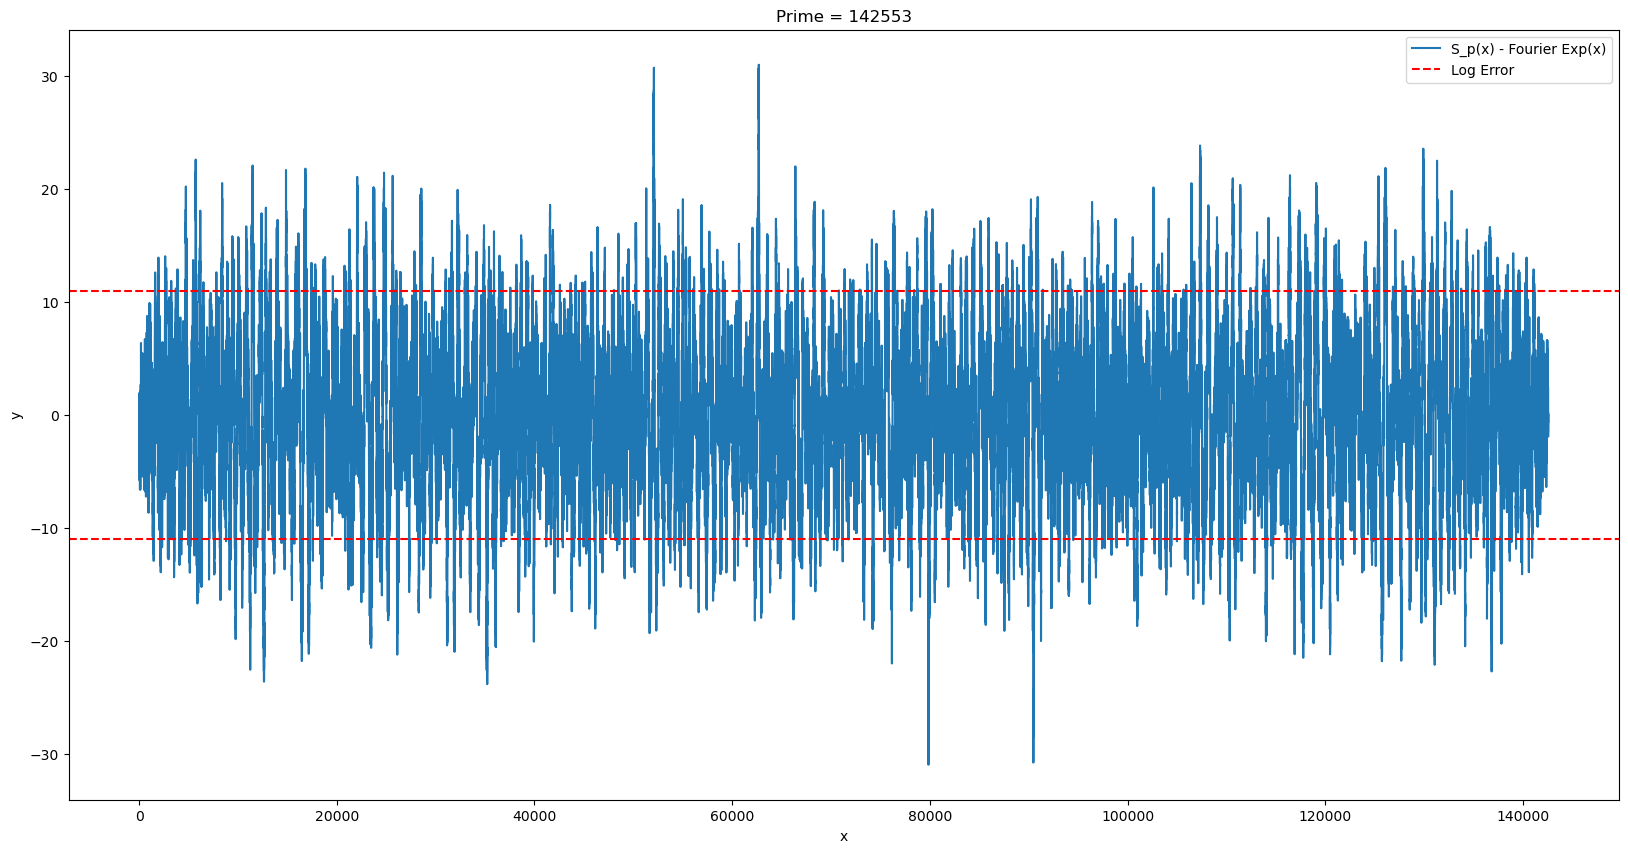


 10%|████                                    | 1/10 [26:17<3:56:39, 1577.71s/it]


Data Collection for Prime = 142553 Complete

P = 144731: Checking Data Repository...

P = 144731: Analyzing Data...

Data: {'prime': 144731, 'max_error': 26.440932977173535, 'max_neg_error': -29.787906017830608, 'x_max_error': [107809], 'x_max_neg_error': [125837]}


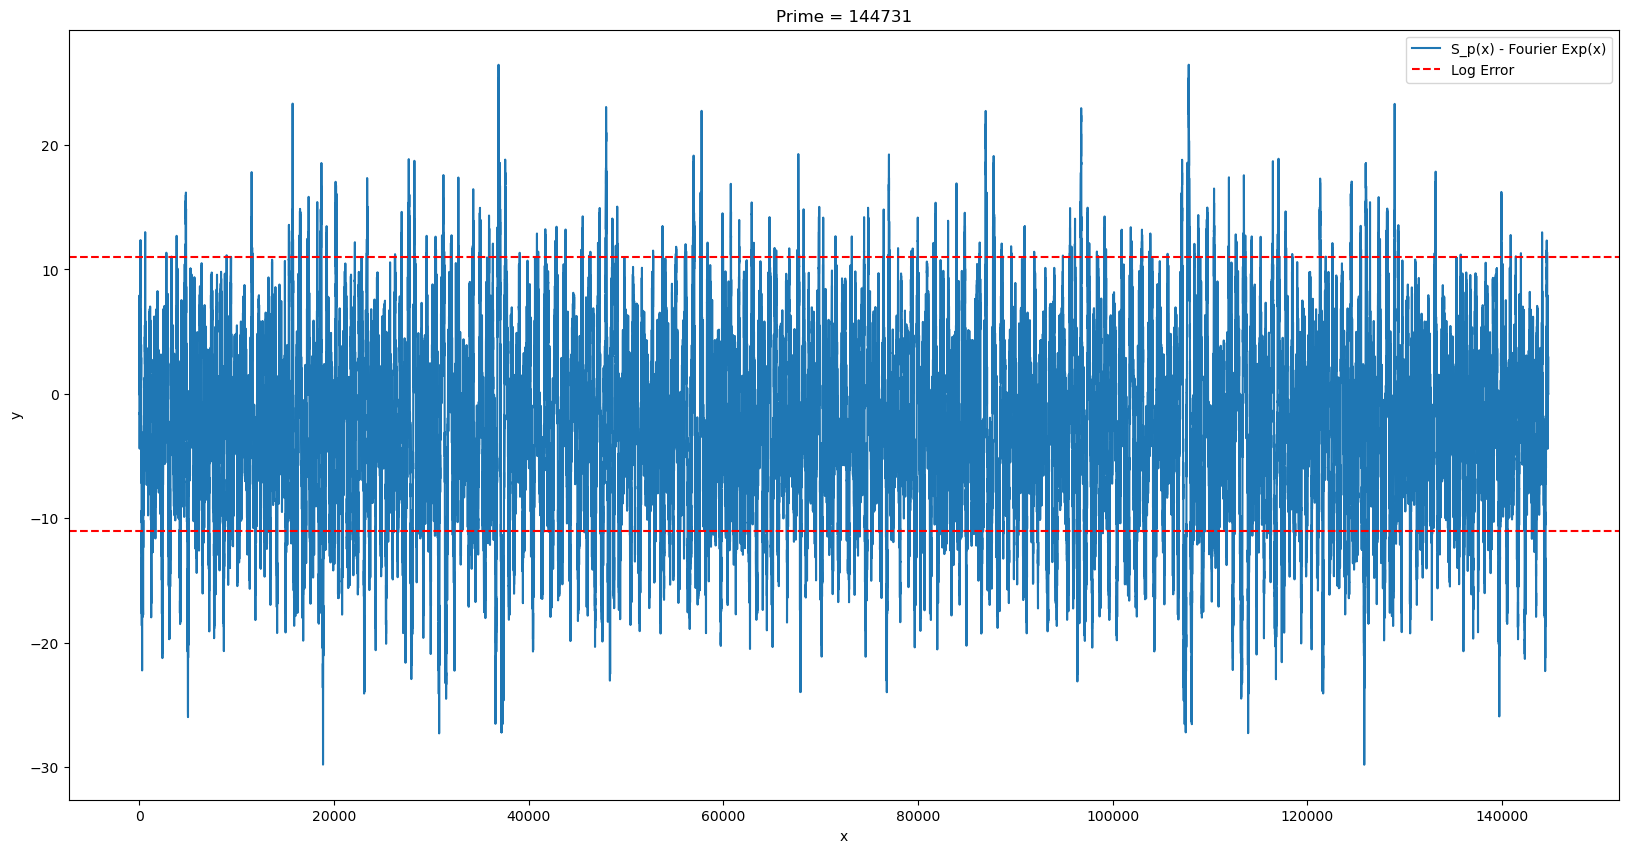


 20%|███████▌                              | 2/10 [1:12:02<5:01:53, 2264.19s/it]


Data Collection for Prime = 144731 Complete

P = 114643: Checking Data Repository...

P = 114643: Analyzing Data...

Data: {'prime': 114643, 'max_error': 20.27335705562917, 'max_neg_error': -26.294249238115835, 'x_max_error': [840], 'x_max_neg_error': [113540]}


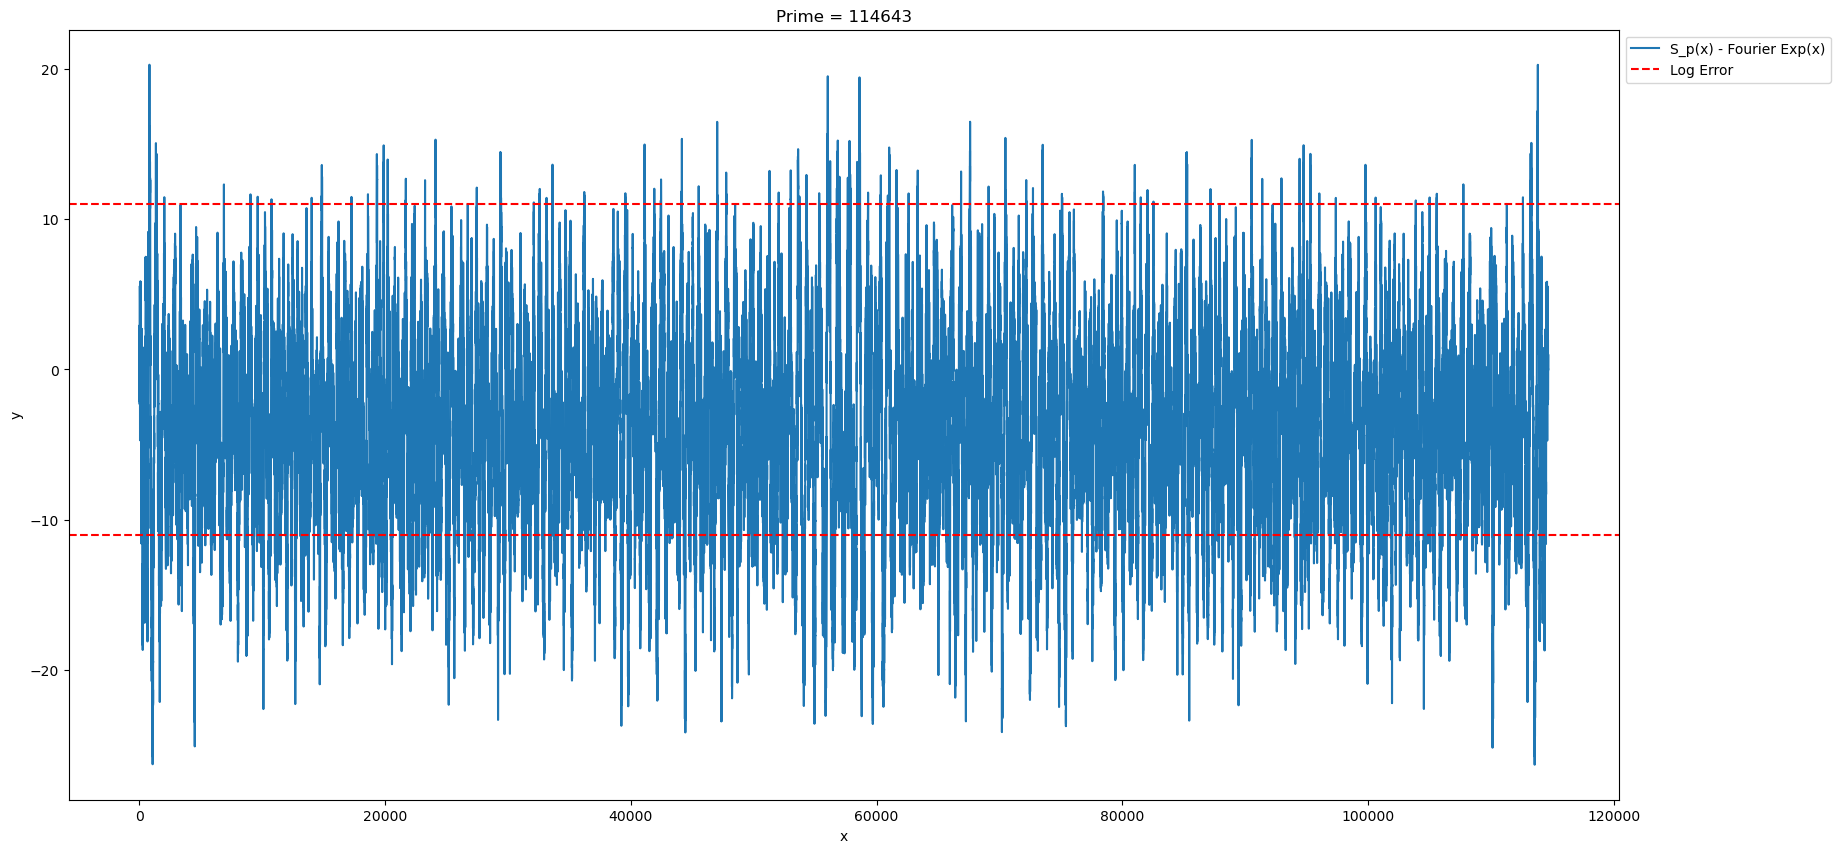


 30%|███████████▍                          | 3/10 [2:21:55<6:06:55, 3145.12s/it]


Data Collection for Prime = 114643 Complete

P = 111467: Checking Data Repository...

P = 111467: Analyzing Data...

Data: {'prime': 111467, 'max_error': 28.18748241813958, 'max_neg_error': -21.59766698479433, 'x_max_error': [35960], 'x_max_neg_error': [23469]}


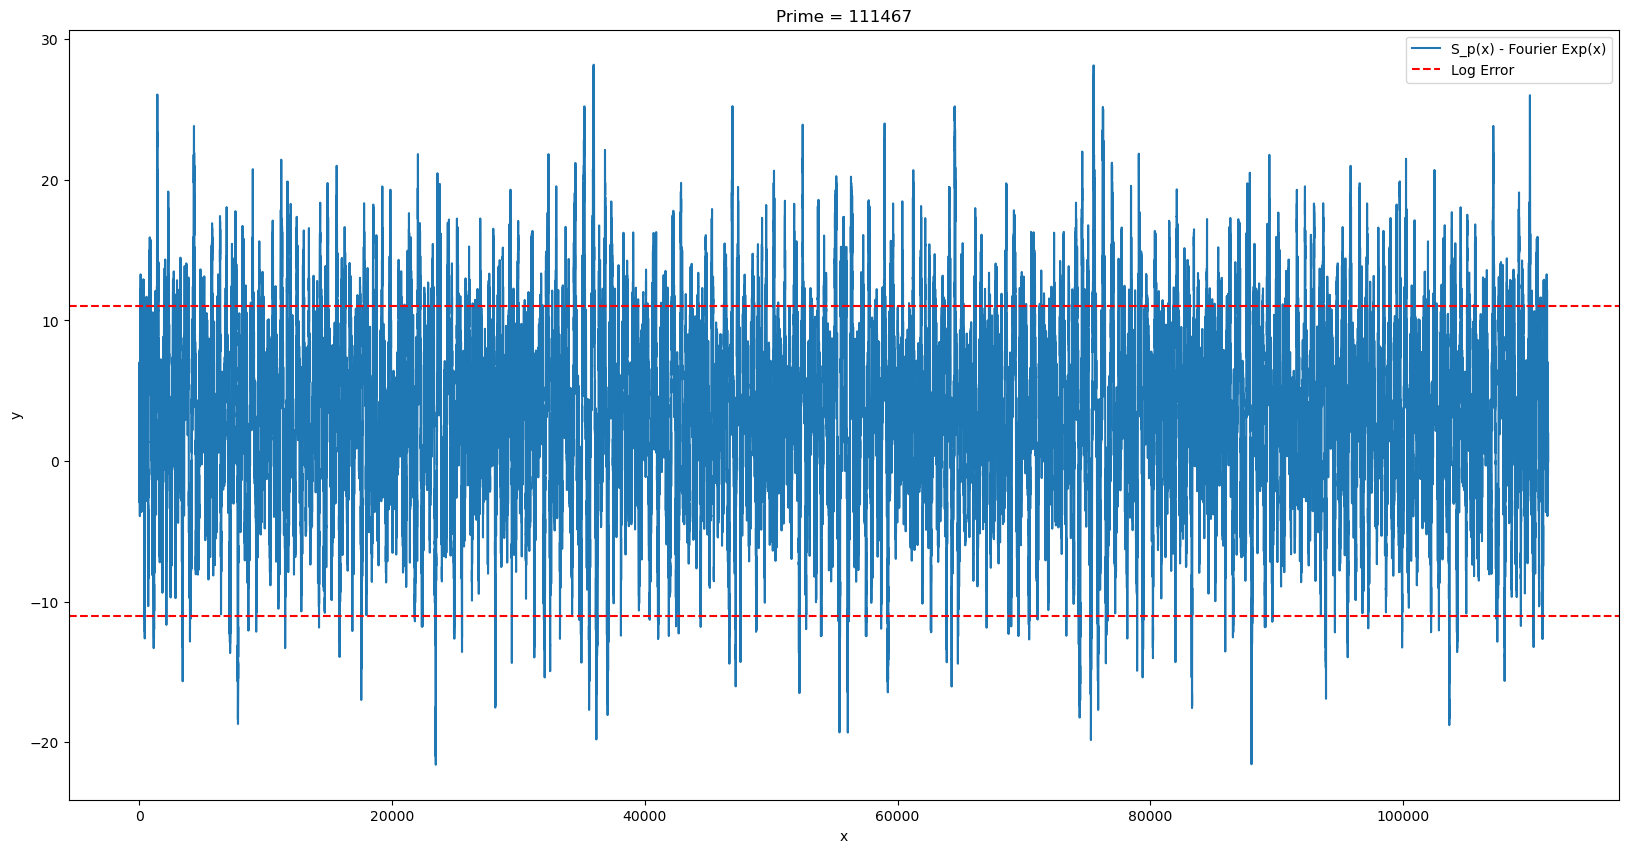


 40%|███████████████▏                      | 4/10 [4:06:33<7:18:11, 4381.88s/it]


Data Collection for Prime = 111467 Complete

P = 120223: Checking Data Repository...

P = 120223: Analyzing Data...

Data: {'prime': 120223, 'max_error': 30.512861162764864, 'max_neg_error': -17.07548144481342, 'x_max_error': [92944], 'x_max_neg_error': [53522]}


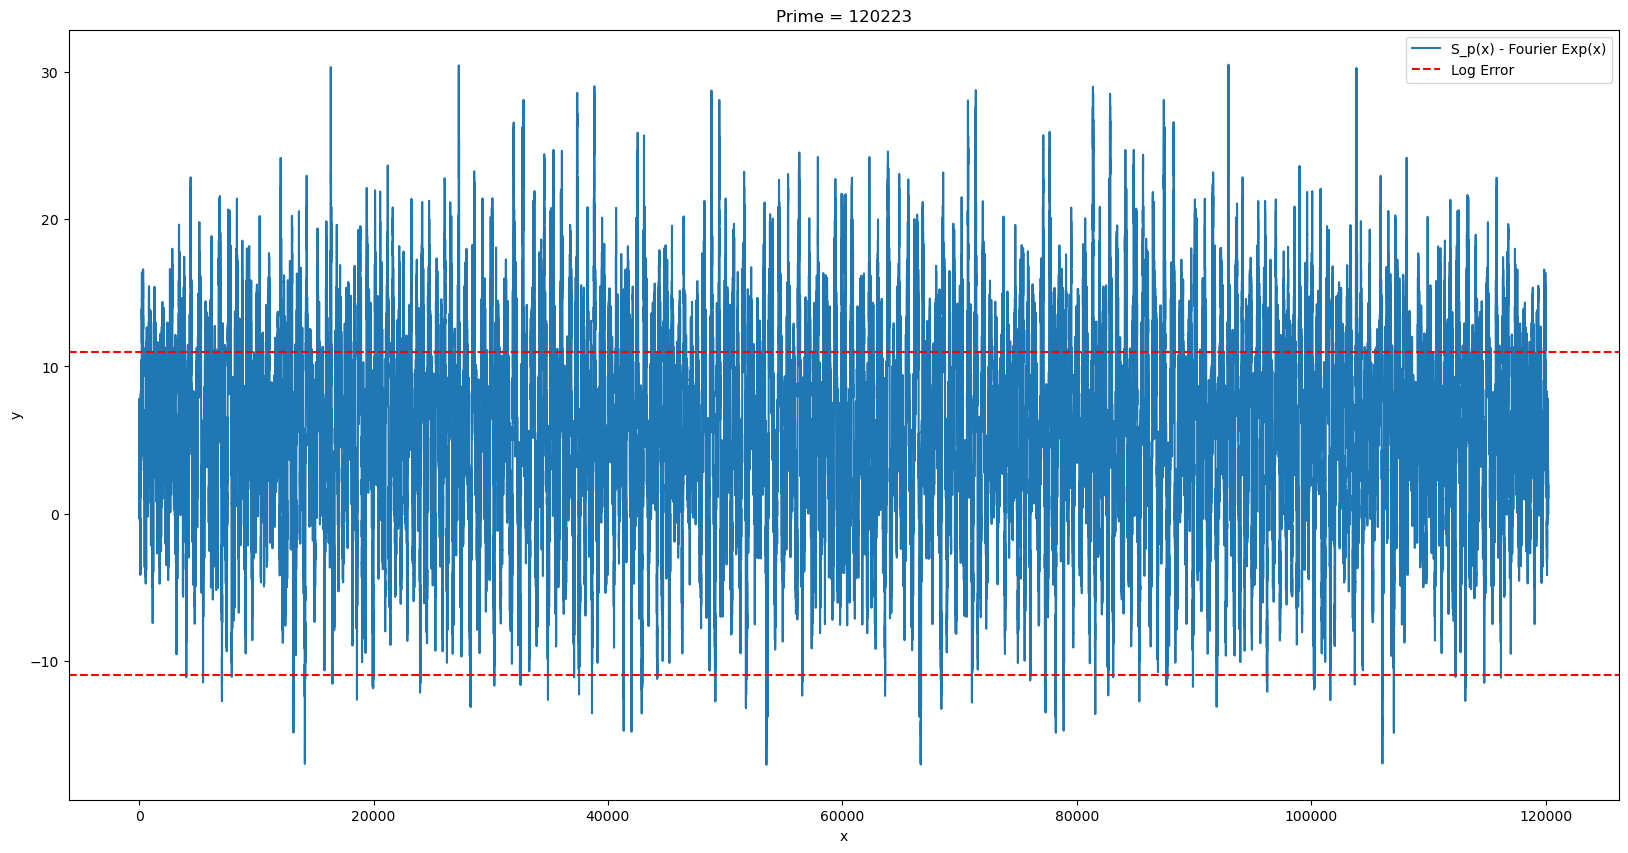


 50%|███████████████████                   | 5/10 [6:24:38<8:02:26, 5789.32s/it]


Data Collection for Prime = 120223 Complete

P = 192187: Checking Data Repository...

P = 192187: Analyzing Data...

Data: {'prime': 192187, 'max_error': 35.85381549994249, 'max_neg_error': -24.466162908263527, 'x_max_error': [182676], 'x_max_neg_error': [38436]}


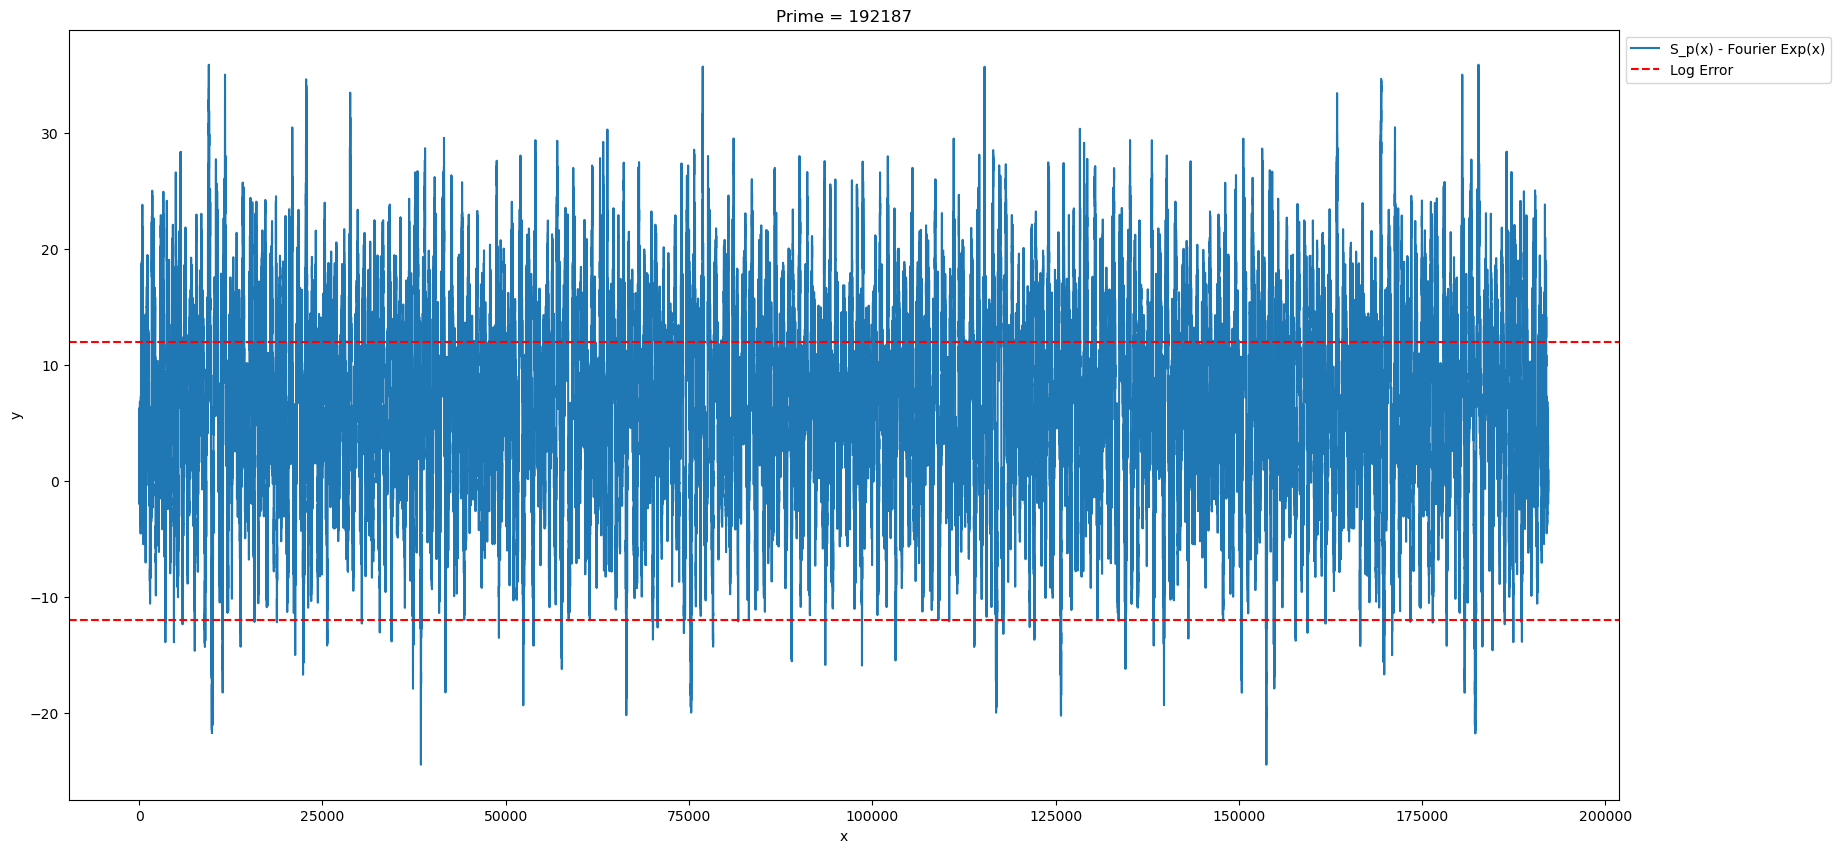


 60%|██████████████████████▊               | 6/10 [9:28:16<8:24:28, 7567.03s/it]


Data Collection for Prime = 192187 Complete

P = 124171: Checking Data Repository...

P = 124171: Analyzing Data...

Data: {'prime': 124171, 'max_error': 39.05566414239553, 'max_neg_error': -10.563414072306347, 'x_max_error': [123858], 'x_max_neg_error': [27577]}


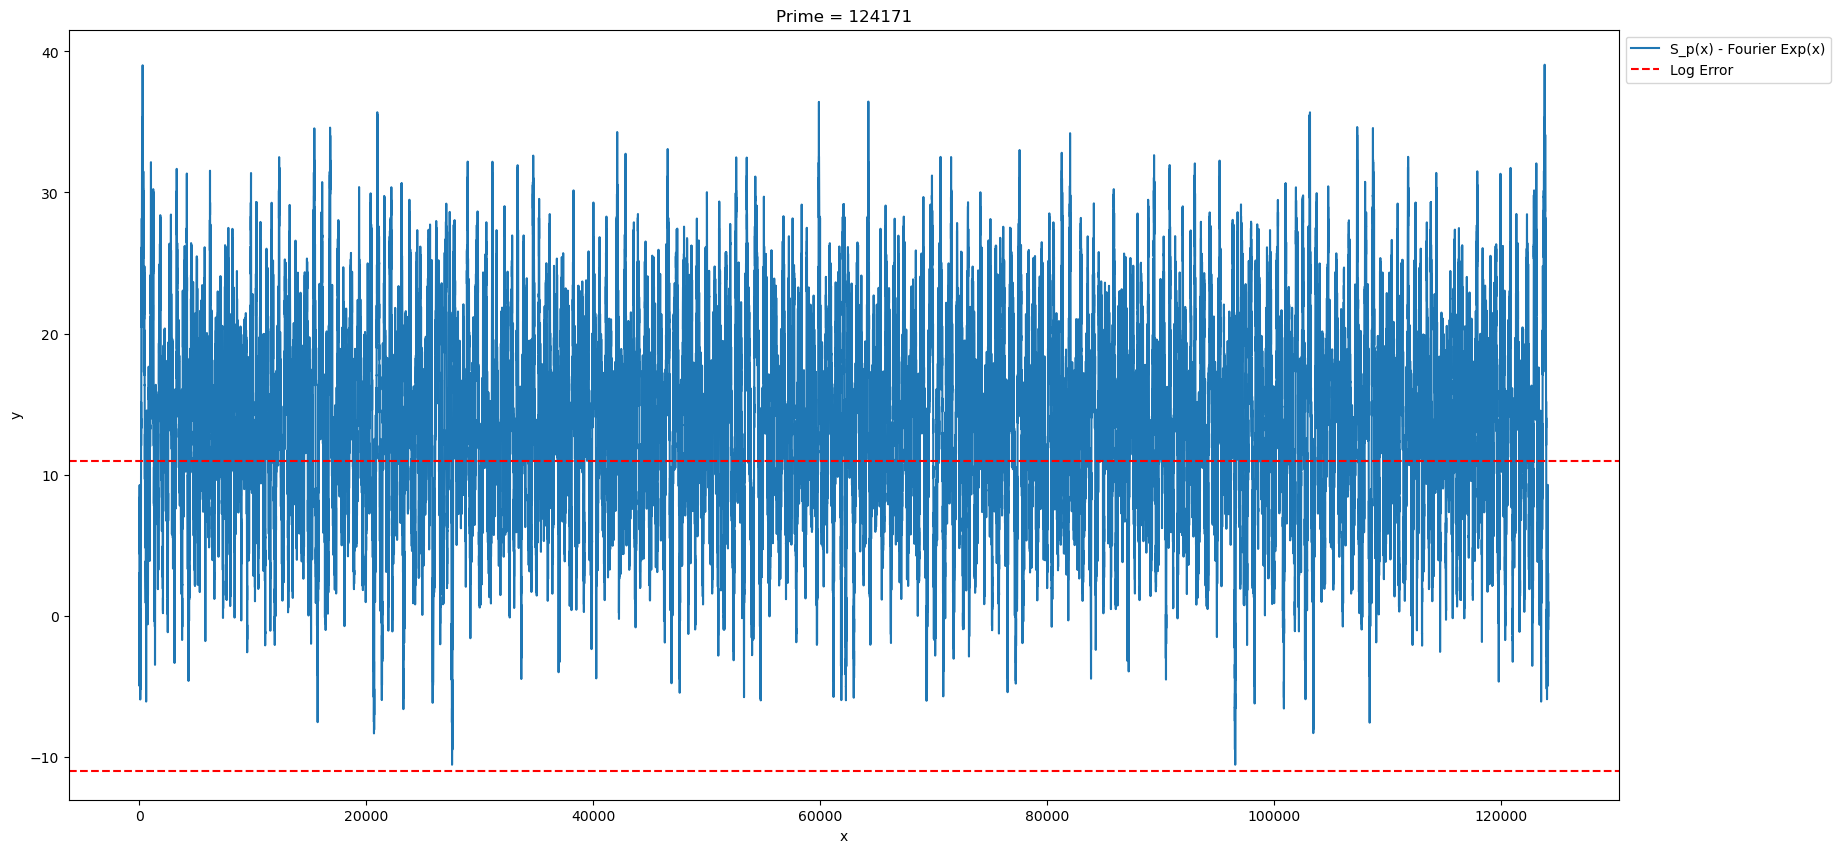


 70%|█████████████████████████▉           | 7/10 [11:10:29<5:54:54, 7098.08s/it]


Data Collection for Prime = 124171 Complete

P = 116803: Checking Data Repository...

P = 116803: Analyzing Data...



In [ ]:
def update_repo(prime_list):
    """
    When you come back just run this again 
    and stop it whenever
    """
    for prime in tqdm(prime_list):
        print(f"P = {prime}: Checking Data Repository...\n")
        

        path = f"{os.getcwd()}/Plots/Prime = {prime} Difference Plot.png"
        
        if not os.path.exists(path):
            print(f"P = {prime}: Analyzing Data...\n")
            
            add_data(prime)
    
    print(f"Dataset Update Complete: N = {len(prime_list)} Primes Processed")

prime_list = sample_primes(10)
update_repo(prime_list)

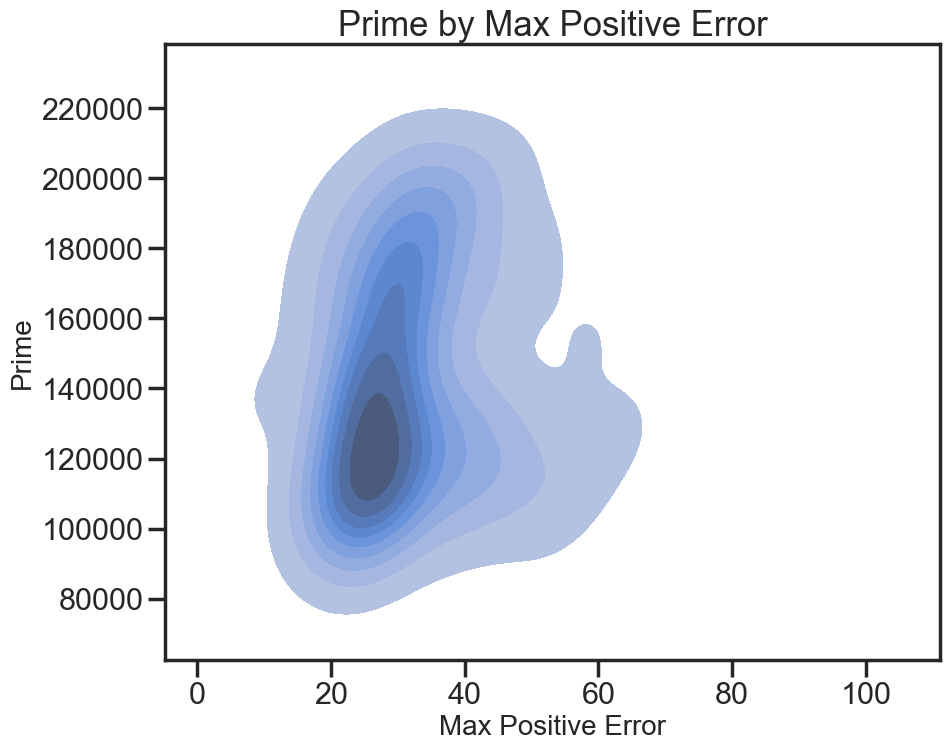

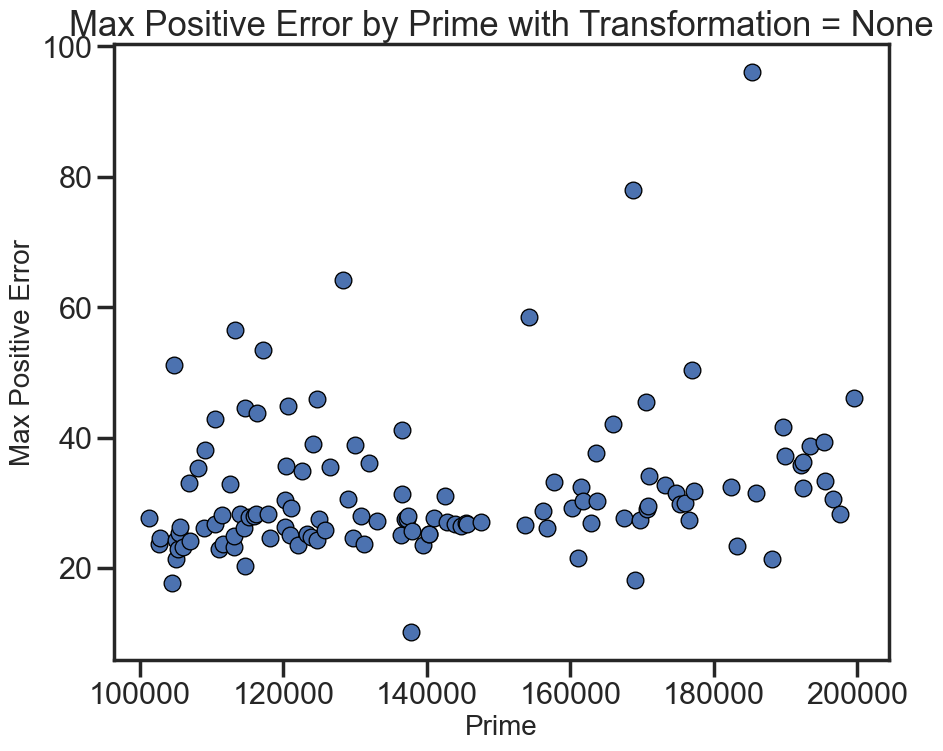

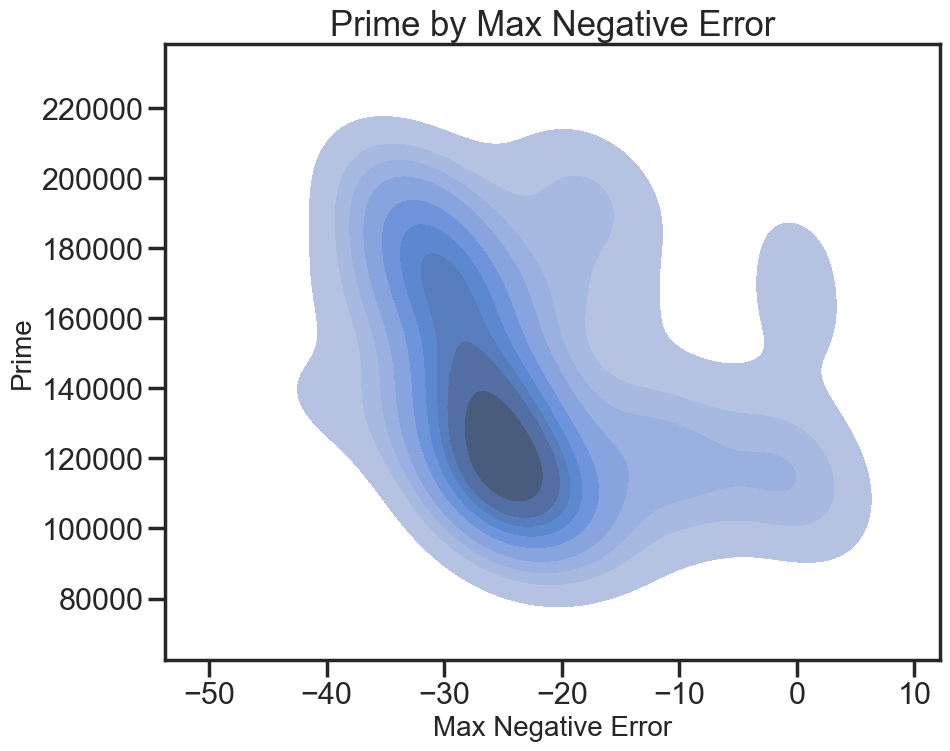

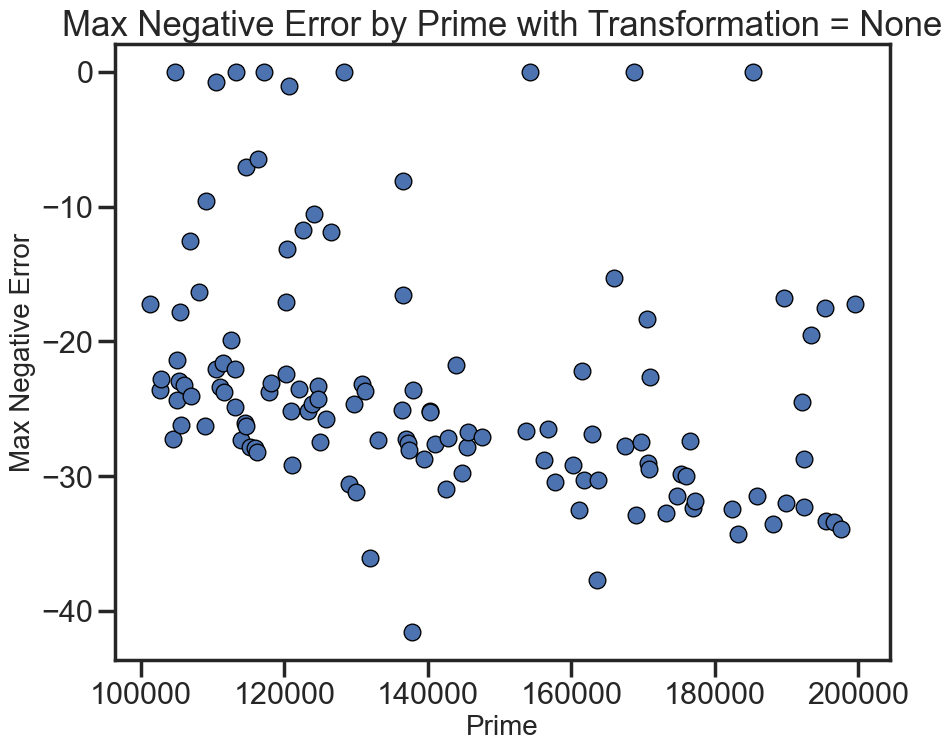

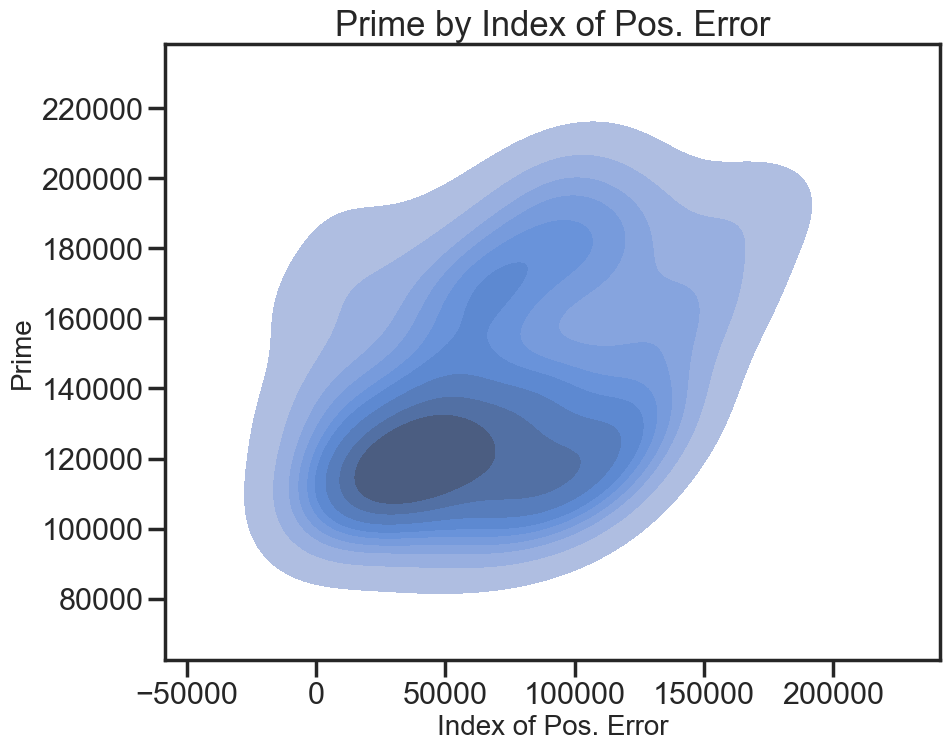

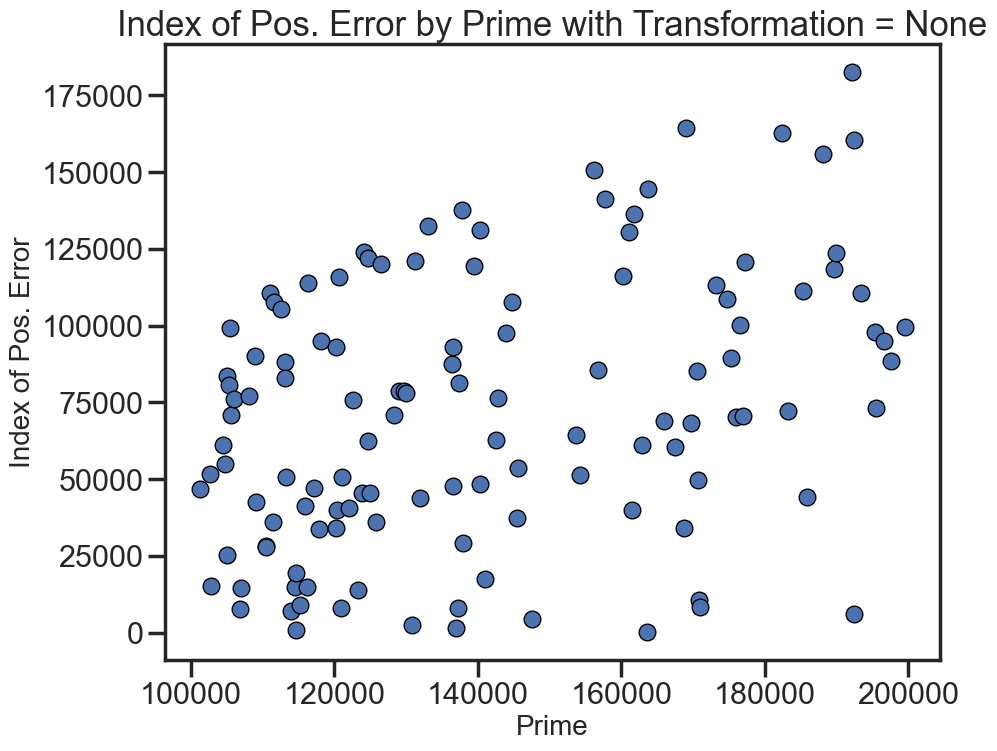

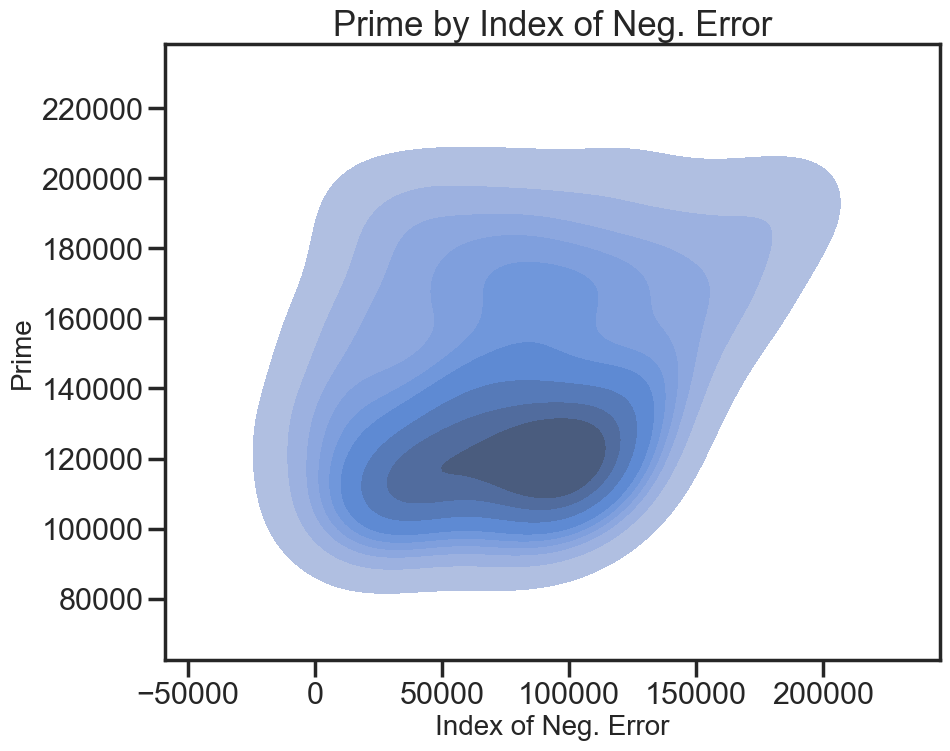

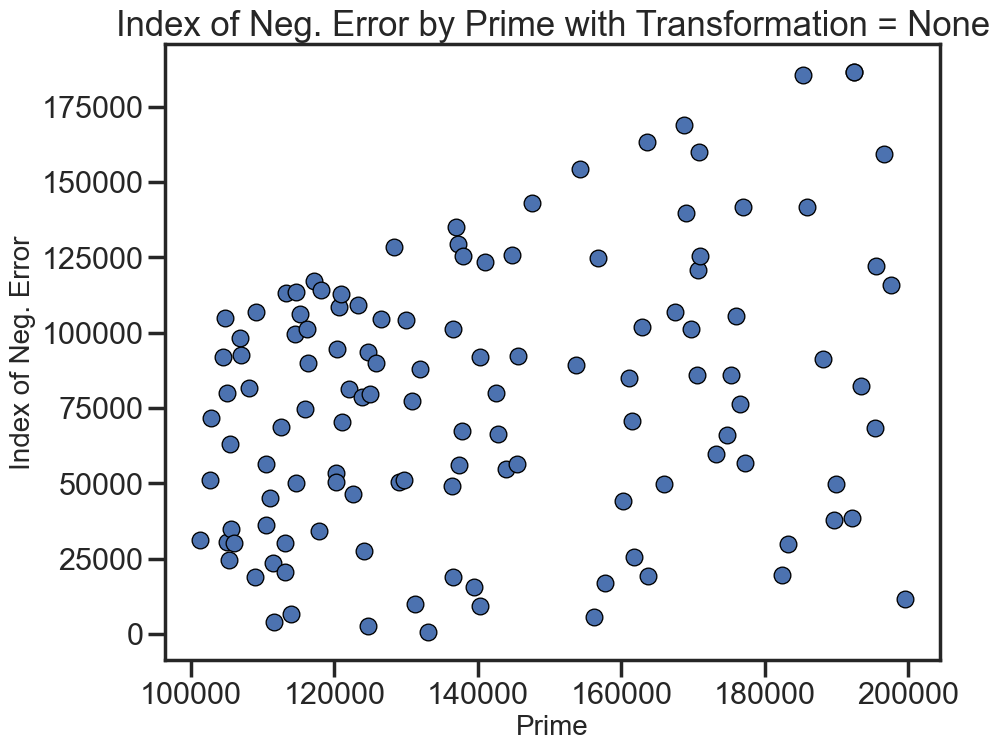

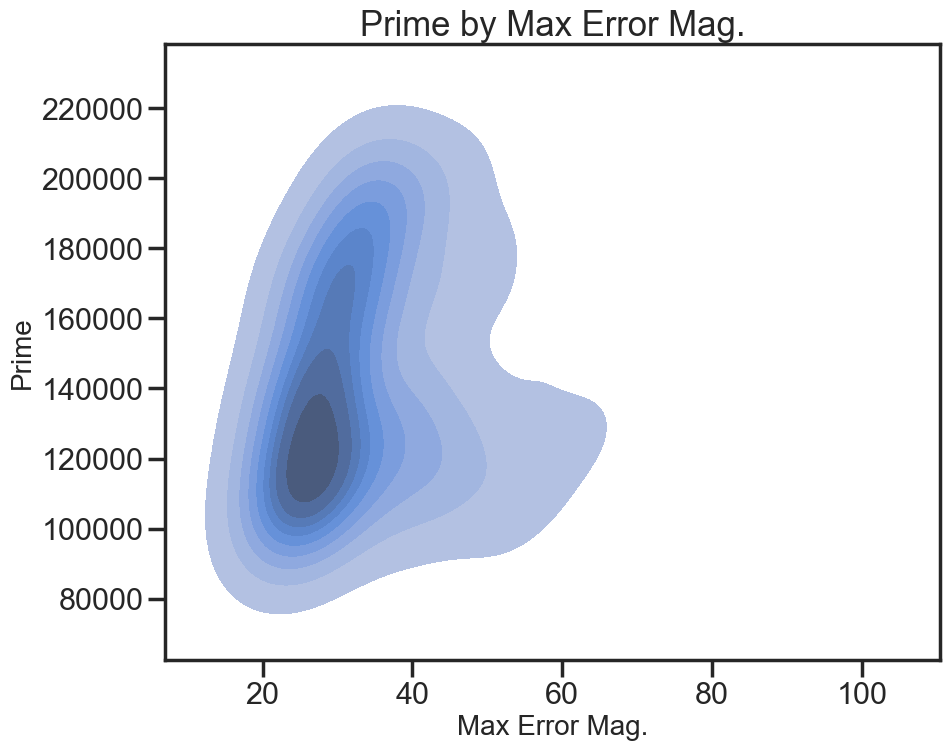

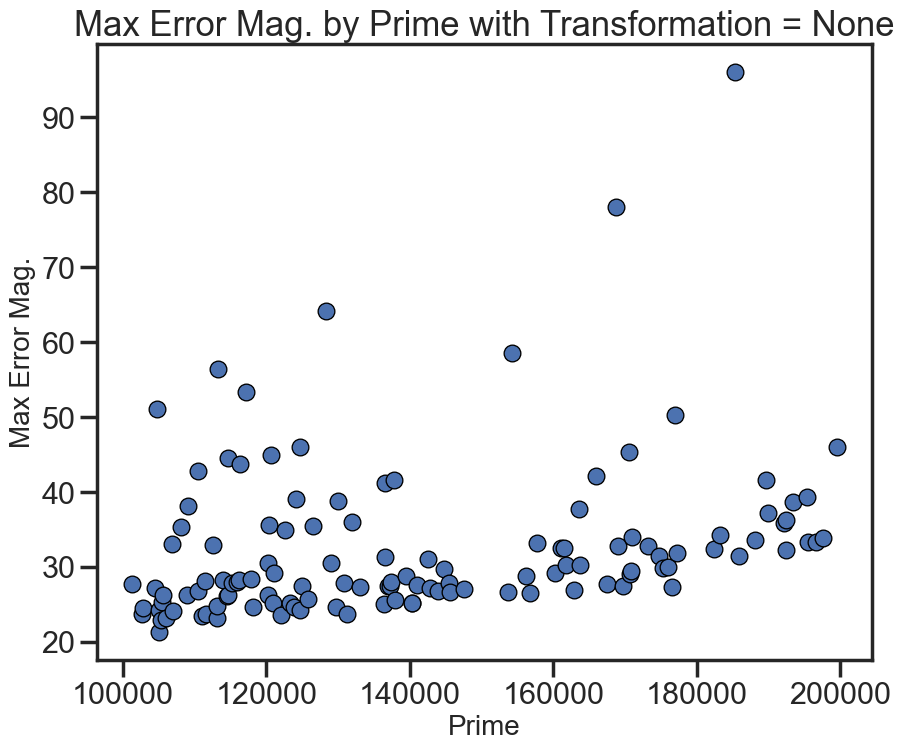

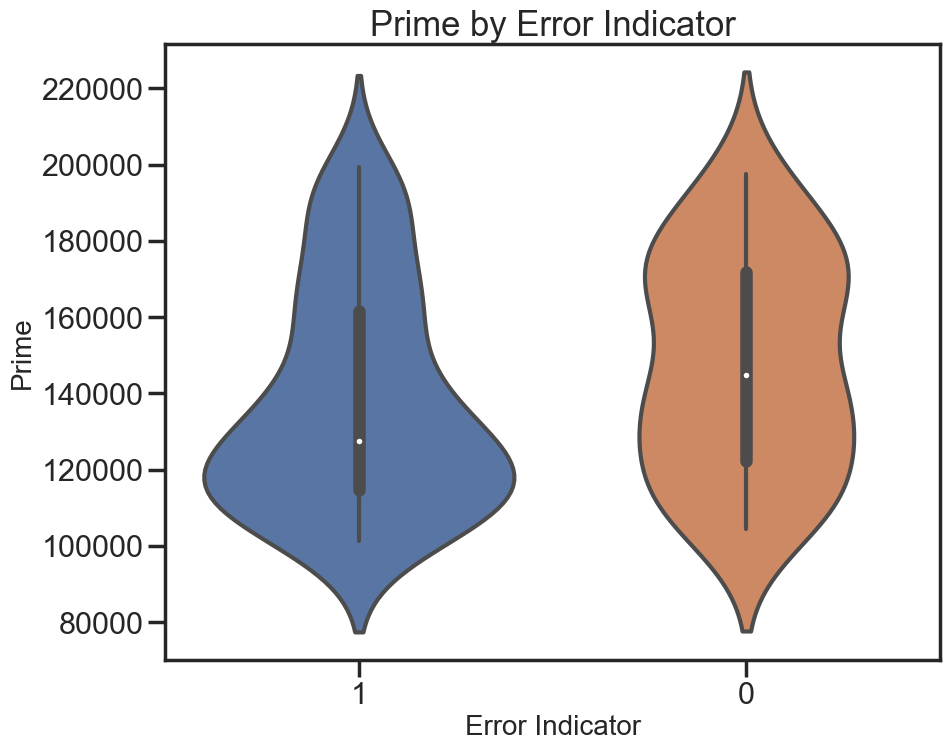

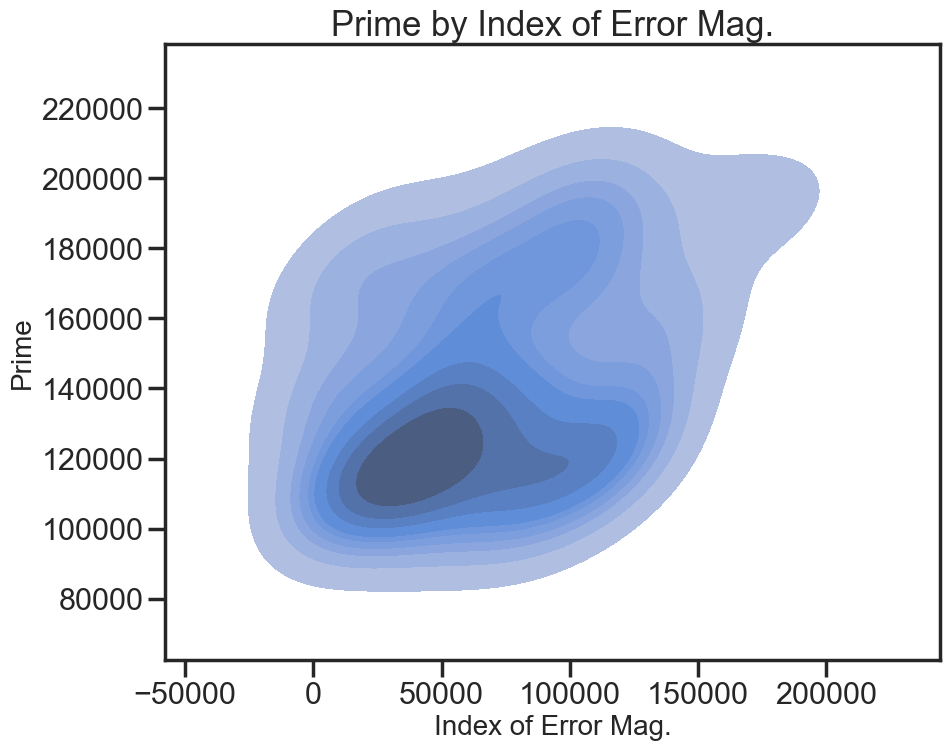

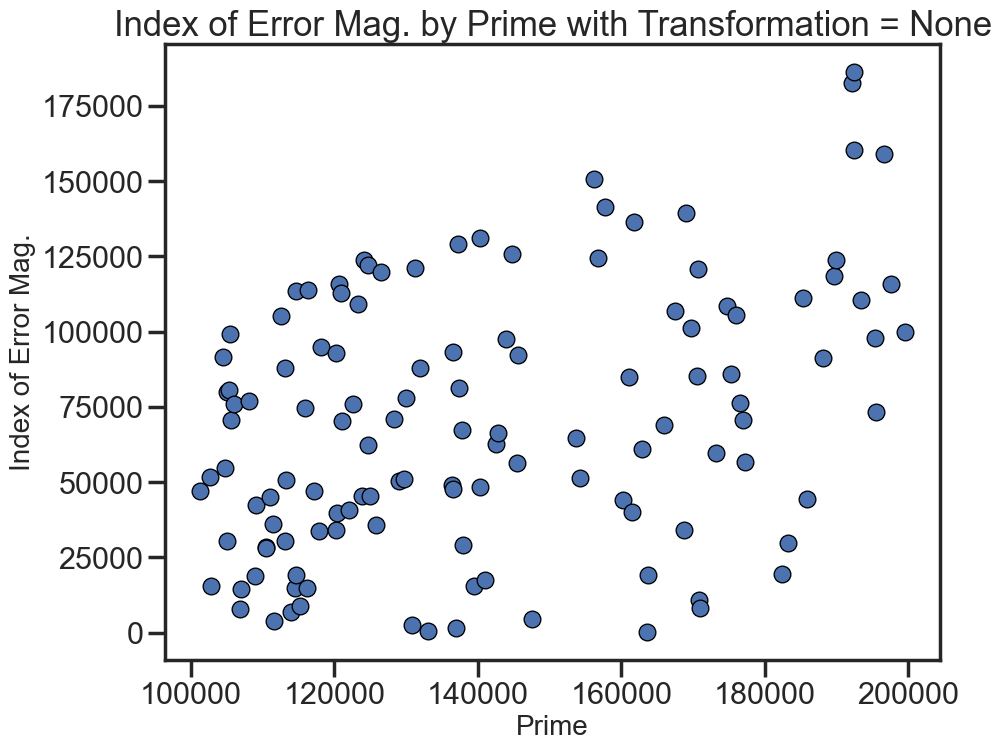

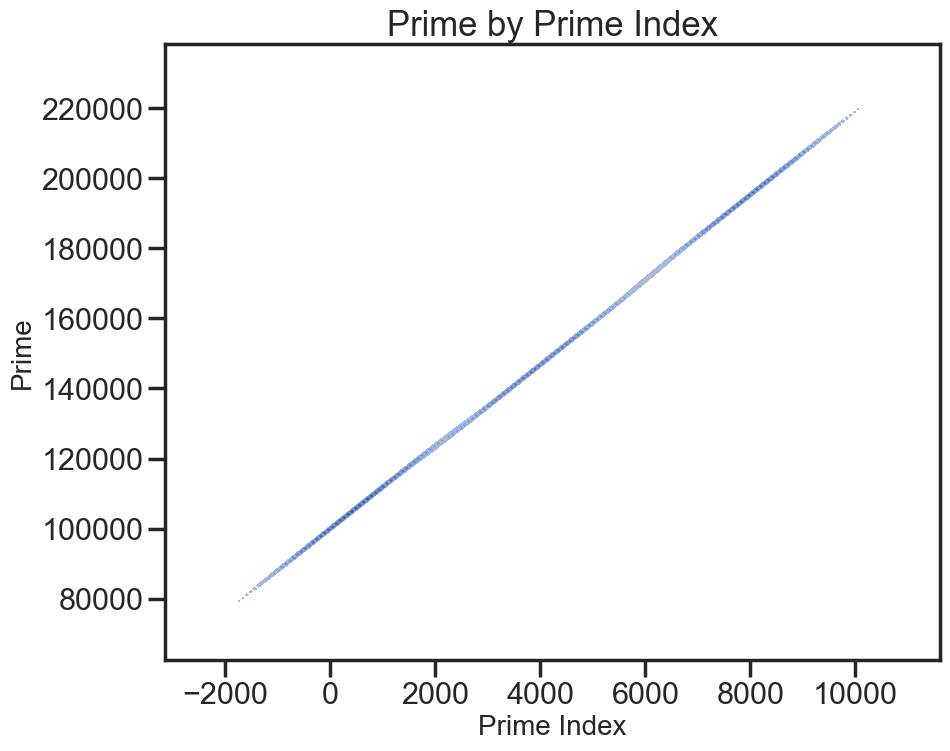

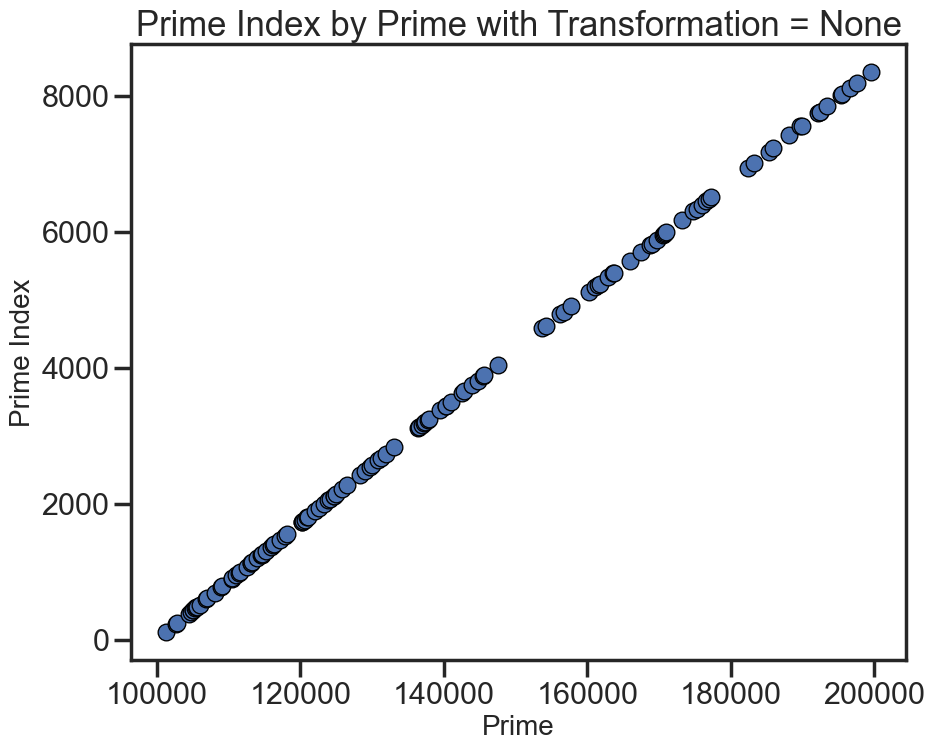

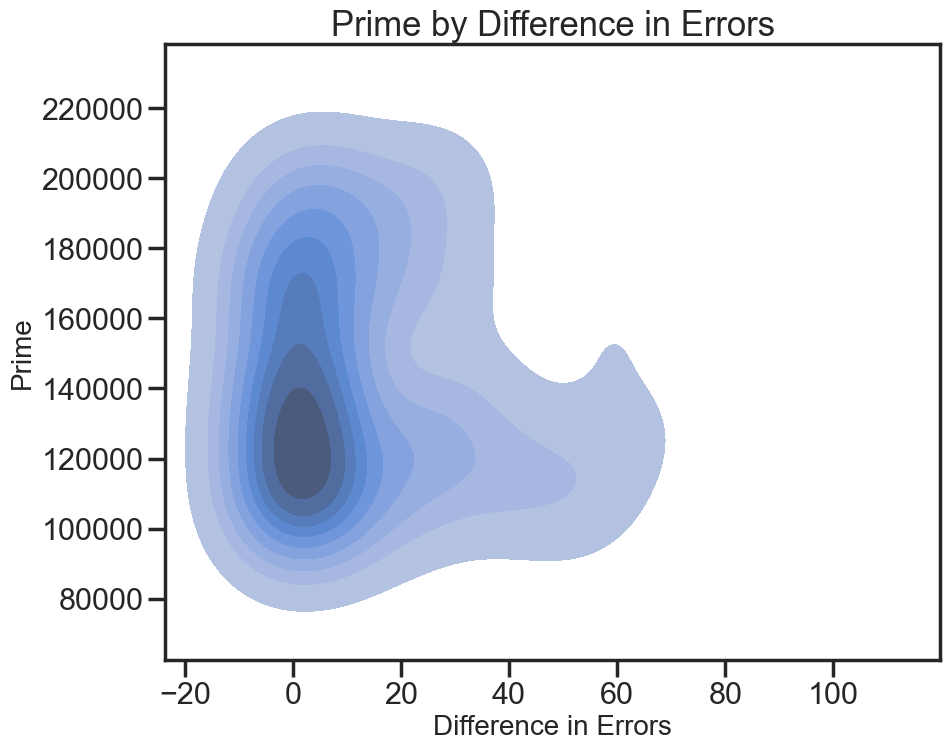

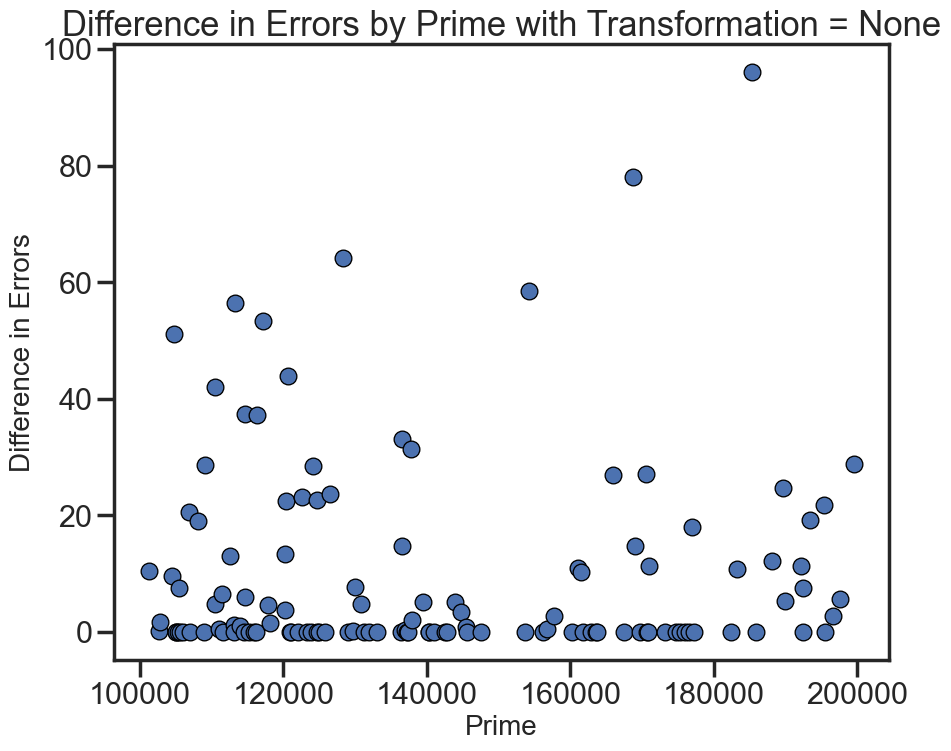

In [129]:
for column in df.columns:
    if column != "prime":
        if column == "max_error_ind":
            violinplot("max_error_ind")
        else:
            kdeplot(column)
            scatter(column)

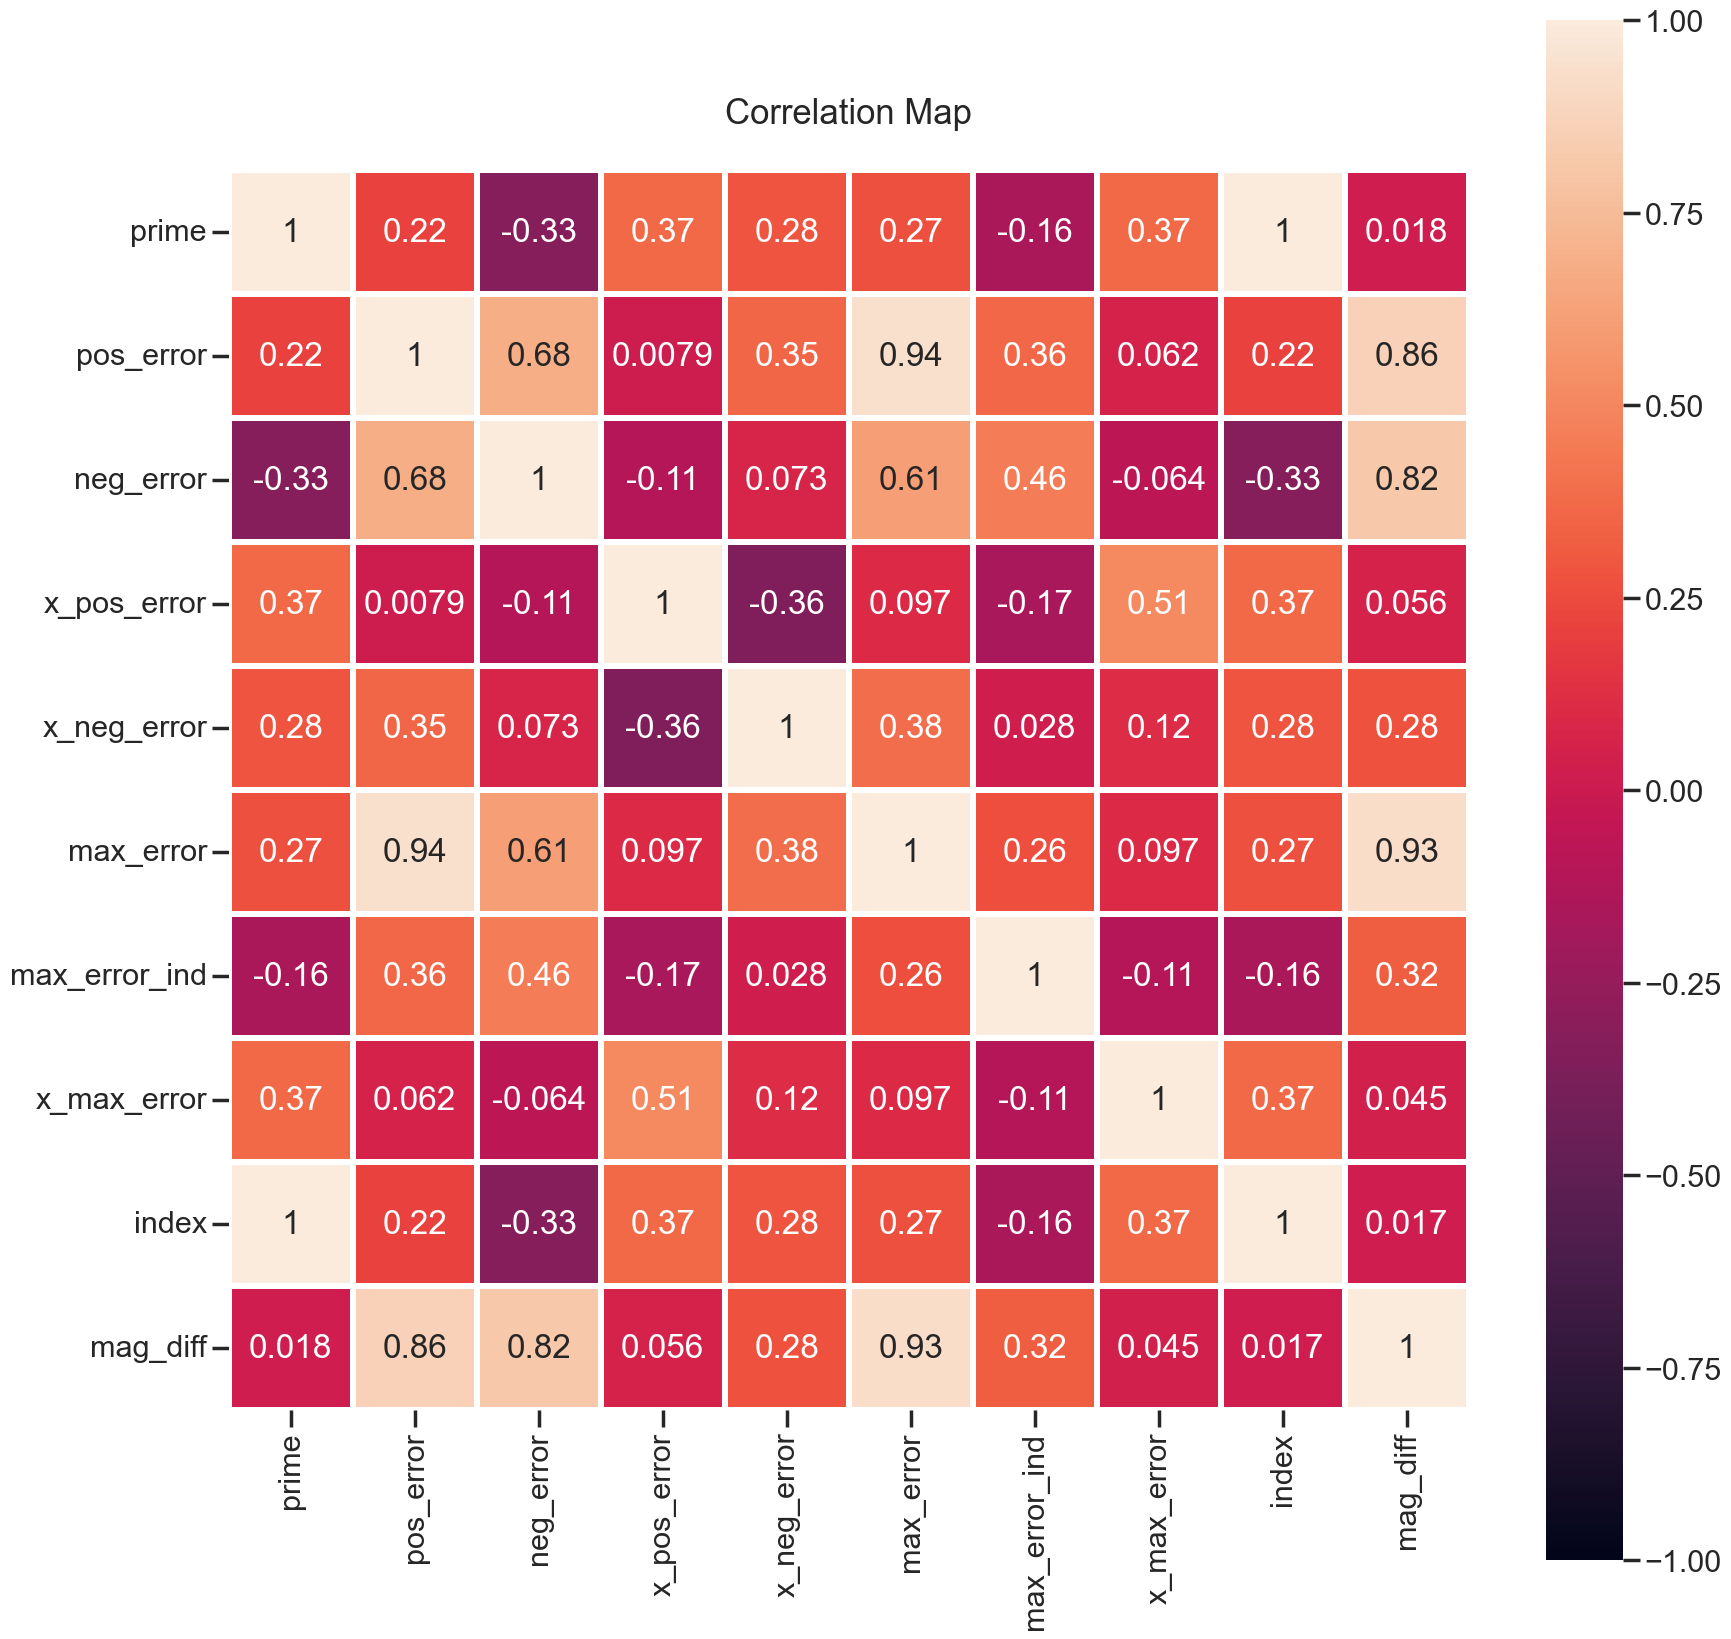